# 🫀 Détection d'anomalies dans des signaux ECG
## Approche Semi-Supervisée avec Autoencodeur Convolutionnel

**Projet :** Traitement de signaux ECG - Licence Informatique 3ème année  
**Objectif :** Détecter les anomalies cardiaques (classes R et V) en entraînant un autoencodeur uniquement sur des signaux normaux (classe N)

---

## 📚 Imports

In [38]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("🫀 PROJET : DÉTECTION D'ANOMALIES DANS LES SIGNAUX ECG")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

🫀 PROJET : DÉTECTION D'ANOMALIES DANS LES SIGNAUX ECG
TensorFlow version: 2.20.0
NumPy version: 2.3.4


---
## 📁 ÉTAPE 1 : Chargement et exploration des données

In [39]:
# Charger le fichier MAT
data = loadmat('ecg_dataset.mat')

# Récupérer X (signaux ECG) et y (classes : 0, 1, 2)
X = data['X']
y = data['y'].flatten()

print(f"✓ Données chargées avec succès")
print(f"  - Nombre total de signaux : {X.shape[0]}")
print(f"  - Longueur de chaque signal : {X.shape[1]} points")
print(f"  - Type de données : {X.dtype}")

print(f"\n{'='*80}")
print("📊 DISTRIBUTION DES CLASSES")
print(f"{'='*80}")

labels_desc = {
    0: "N (Battements normaux)",
    1: "R (Anomalies connues - extrasystoles)",
    2: "V (Anomalies inconnues - fibrillation ventriculaire)"
}

for classe in [0, 1, 2]:
    count = np.sum(y == classe)
    percentage = count/len(y)*100
    bar = '█' * int(percentage / 2)
    print(f"Classe {classe} - {labels_desc[classe]:50s}")
    print(f"  {bar} {count:4d} ({percentage:5.1f}%)\n")

✓ Données chargées avec succès
  - Nombre total de signaux : 5405
  - Longueur de chaque signal : 146 points
  - Type de données : float64

📊 DISTRIBUTION DES CLASSES
Classe 0 - N (Battements normaux)                            
  ████████████████████████████████████████████████ 5288 ( 97.8%)

Classe 1 - R (Anomalies connues - extrasystoles)             
  █  111 (  2.1%)

Classe 2 - V (Anomalies inconnues - fibrillation ventriculaire)
      6 (  0.1%)



---
## 📊 ÉTAPE 2 : Visualisation des signaux par classe

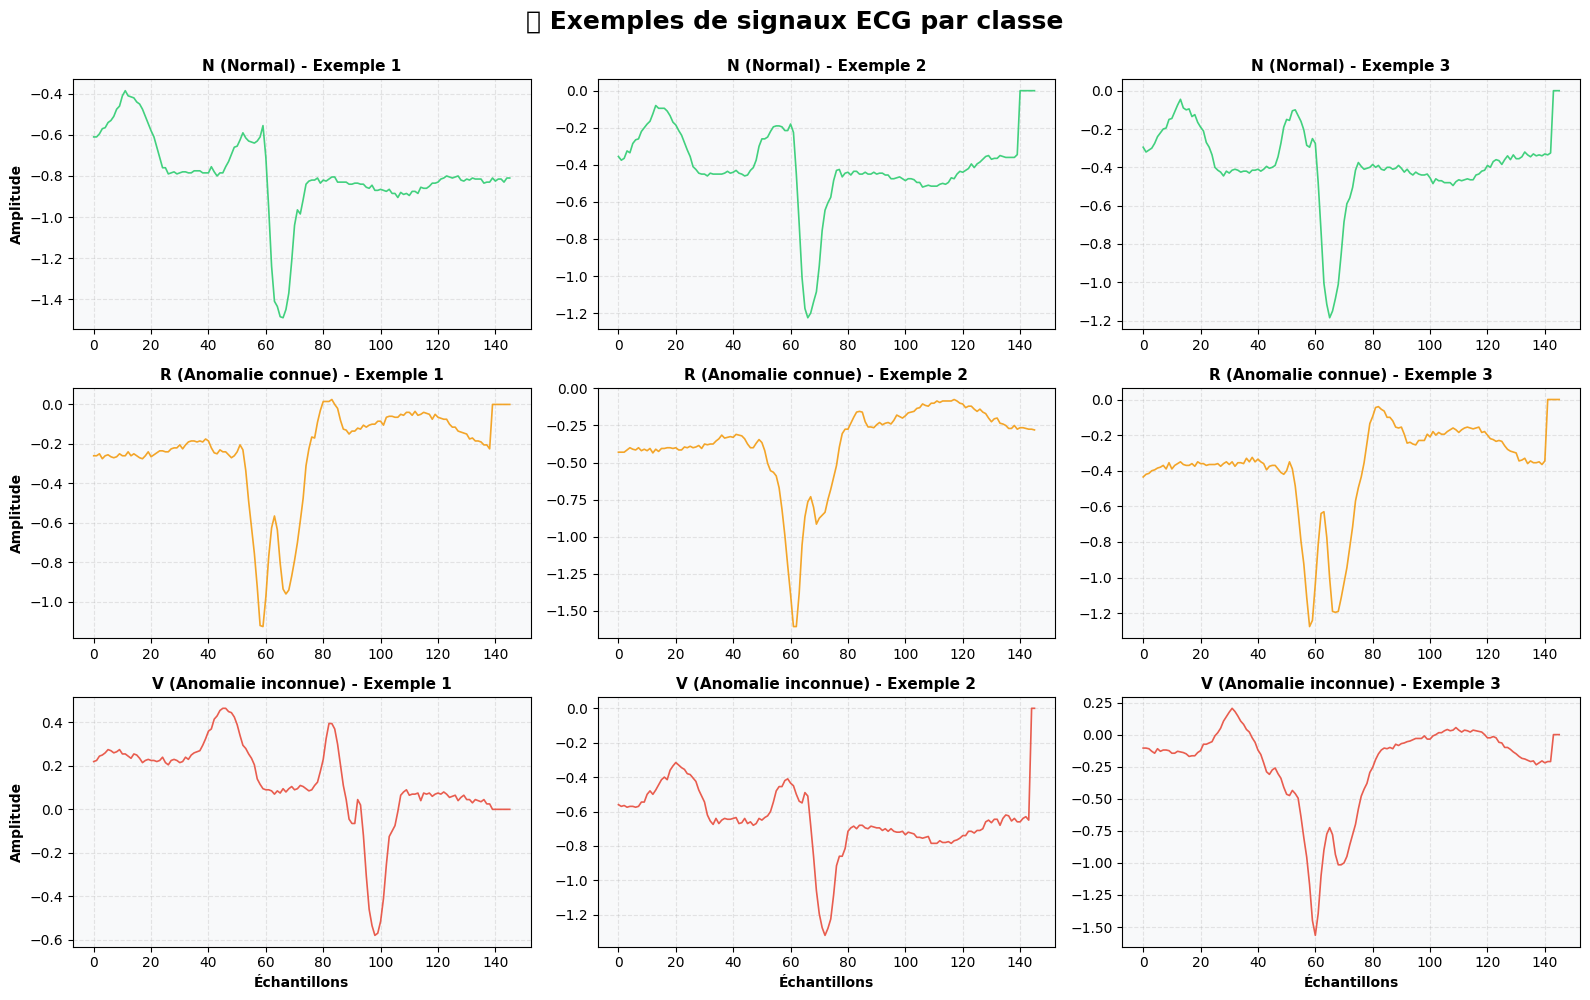

✓ Visualisation terminée - Observations :
  • Classe N : Signaux réguliers avec pattern typique (ondes P, QRS, T)
  • Classe R : Variations dans la morphologie des ondes
  • Classe V : Patterns très différents, irréguliers


In [40]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('📈 Exemples de signaux ECG par classe', fontsize=18, fontweight='bold', y=0.995)

labels = {0: "N (Normal)", 1: "R (Anomalie connue)", 2: "V (Anomalie inconnue)"}
colors = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}

for i, classe in enumerate([0, 1, 2]):
    indices = np.where(y == classe)[0]
    for j in range(3):
        idx = indices[j]
        axes[i, j].plot(X[idx], linewidth=1.2, color=colors[classe], alpha=0.9)
        axes[i, j].set_title(f"{labels[classe]} - Exemple {j+1}", fontsize=11, fontweight='bold')
        axes[i, j].grid(True, alpha=0.3, linestyle='--')
        axes[i, j].set_facecolor('#f8f9fa')
        
        if j == 0:
            axes[i, j].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
        if i == 2:
            axes[i, j].set_xlabel('Échantillons', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualisation terminée - Observations :")
print("  • Classe N : Signaux réguliers avec pattern typique (ondes P, QRS, T)")
print("  • Classe R : Variations dans la morphologie des ondes")
print("  • Classe V : Patterns très différents, irréguliers")

---
## 🔧 ÉTAPE 3 : Préparation des données (Approche Semi-Supervisée)

### 🎯 Stratégie :
- **Entraînement** : Uniquement la classe N (signaux normaux)
- **Test** : Classes R et V (pour détecter les anomalies)
- **Principe** : Le modèle n'aura **JAMAIS** vu les anomalies pendant l'entraînement

### 💡 Pourquoi cette approche ?
- Les anomalies de classe V sont rares et mal caractérisées
- Un autoencodeur entraîné sur des signaux normaux apprendra leur structure
- Les anomalies produiront une **forte erreur de reconstruction**

In [41]:
# Séparer les signaux normaux (classe 0)
X_good = X[y == 0]

print(f"{'='*80}")
print("🔍 SÉPARATION DES DONNÉES")
print(f"{'='*80}")
print(f"\n✓ Signaux normaux extraits : {X_good.shape[0]} signaux")
print(f"  → Utilisation : ENTRAÎNEMENT uniquement")
print(f"  → Objectif : Apprendre à reconstruire les signaux normaux")
print(f"\n✓ Signaux anomalies (R+V) : {np.sum(y != 0)} signaux")
print(f"  → Utilisation : TEST de détection")
print(f"  → Le modèle ne les verra PAS pendant l'entraînement")

🔍 SÉPARATION DES DONNÉES

✓ Signaux normaux extraits : 5288 signaux
  → Utilisation : ENTRAÎNEMENT uniquement
  → Objectif : Apprendre à reconstruire les signaux normaux

✓ Signaux anomalies (R+V) : 117 signaux
  → Utilisation : TEST de détection
  → Le modèle ne les verra PAS pendant l'entraînement


---
## 📐 ÉTAPE 4 : Normalisation des données

**Méthode** : Z-score normalization (standardisation)  
**Formule** : $z = \frac{x - \mu}{\sigma}$

**Avantages** :
- Moyenne = 0, Écart-type = 1
- Améliore la convergence du modèle
- Réduit l'influence de l'échelle des données

✓ Normalisation appliquée aux signaux normaux
  - Moyenne avant : -0.364755 → après : 0.000000
  - Écart-type avant : 0.298283 → après : 1.000000


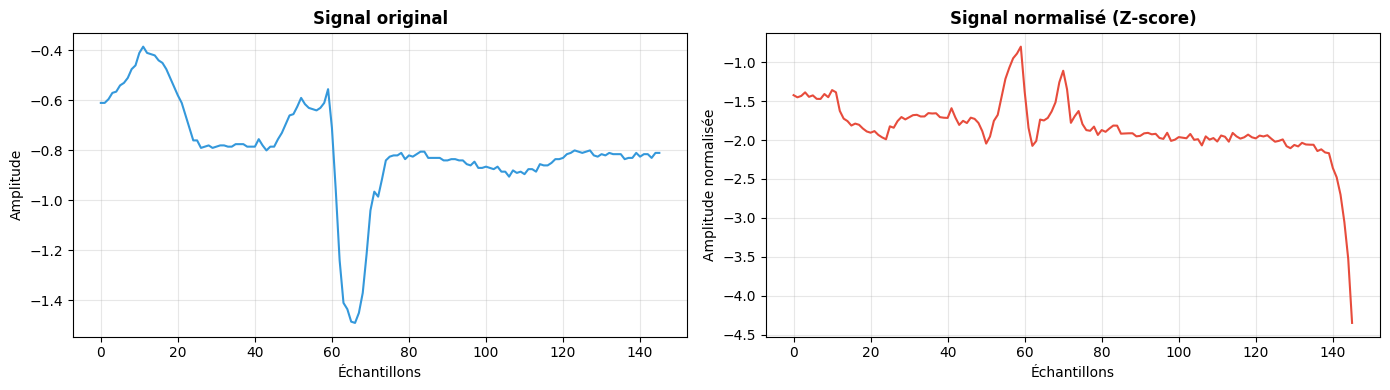

In [42]:
def normalize_data(X):
    """
    Normalise les données (Z-score normalization)
    
    Args:
        X: array de shape (n_samples, n_features)
    
    Returns:
        X_normalized: array normalisé (moyenne=0, std=1)
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Éviter la division par zéro
    std[std == 0] = 1
    return (X - mean) / std

# Normaliser les signaux normaux
X_good_normalized = normalize_data(X_good)

print("✓ Normalisation appliquée aux signaux normaux")
print(f"  - Moyenne avant : {np.mean(X_good):.6f} → après : {np.mean(X_good_normalized):.6f}")
print(f"  - Écart-type avant : {np.std(X_good):.6f} → après : {np.std(X_good_normalized):.6f}")

# Visualiser l'effet de la normalisation
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
idx_example = 0

axes[0].plot(X_good[idx_example], color='#3498db', linewidth=1.5)
axes[0].set_title('Signal original', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Échantillons')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(X_good_normalized[idx_example], color='#e74c3c', linewidth=1.5)
axes[1].set_title('Signal normalisé (Z-score)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Échantillons')
axes[1].set_ylabel('Amplitude normalisée')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## ✂️ ÉTAPE 5 : Division Entraînement / Validation

In [43]:
# Diviser les données (80% train / 20% validation)
X_train, X_val = train_test_split(X_good_normalized, test_size=0.2, random_state=42)

# Reshape pour TensorFlow : (n_samples, 146, 1)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"{'='*80}")
print("📊 DIVISION DES DONNÉES")
print(f"{'='*80}")
print(f"\n✓ Ensemble d'entraînement : {X_train.shape[0]:4d} signaux ({X_train.shape[0]/len(X_good)*100:.0f}%)")
print(f"✓ Ensemble de validation   : {X_val.shape[0]:4d} signaux ({X_val.shape[0]/len(X_good)*100:.0f}%)")
print(f"\n✓ Shape finale des données : {X_train.shape}")
print(f"  - {X_train.shape[0]} échantillons")
print(f"  - {X_train.shape[1]} points temporels")
print(f"  - {X_train.shape[2]} canal (signal 1D)")

📊 DIVISION DES DONNÉES

✓ Ensemble d'entraînement : 4230 signaux (80%)
✓ Ensemble de validation   : 1058 signaux (20%)

✓ Shape finale des données : (4230, 146, 1)
  - 4230 échantillons
  - 146 points temporels
  - 1 canal (signal 1D)


---
## 🏗️ ÉTAPE 6 : Construction de l'Autoencodeur

### 🎨 Architecture Choisie : **Autoencodeur Convolutionnel**

#### 📊 Structure :
```
Input (146, 1)
    ↓
[ENCODEUR]
Conv1D(64) + BatchNorm + MaxPool + Dropout
Conv1D(32) + BatchNorm + MaxPool + Dropout  
Conv1D(16) + BatchNorm + MaxPool → Espace latent compressé
    ↓
[DÉCODEUR]
Conv1D(16) + BatchNorm + UpSample
Conv1D(32) + BatchNorm + UpSample
Conv1D(64) + BatchNorm + UpSample
    ↓
Output (146, 1)
```

#### ✅ Avantages :
- **Conv1D** : Capture les patterns temporels (ondes P, QRS, T)
- **BatchNormalization** : Stabilise l'entraînement
- **Dropout** : Évite l'overfitting
- **Architecture symétrique** : Facilite la reconstruction

In [44]:
def create_autoencoder(input_shape=(146, 1)):
    """
    Crée un autoencodeur convolutionnel pour signaux ECG.
    
    Args:
        input_shape: tuple, shape des données d'entrée
    
    Returns:
        autoencoder: modèle Keras compilé
    """
    inputs = layers.Input(shape=input_shape, name='input')
    
    # ========== ENCODEUR ==========
    # Bloc 1 : 146 → 73
    x = layers.Conv1D(64, 7, activation='relu', padding='same', name='enc_conv1')(inputs)
    x = layers.BatchNormalization(name='enc_bn1')(x)
    x = layers.MaxPooling1D(2, padding='same', name='enc_pool1')(x)
    x = layers.Dropout(0.2, name='enc_drop1')(x)
    
    # Bloc 2 : 73 → 37
    x = layers.Conv1D(32, 7, activation='relu', padding='same', name='enc_conv2')(x)
    x = layers.BatchNormalization(name='enc_bn2')(x)
    x = layers.MaxPooling1D(2, padding='same', name='enc_pool2')(x)
    x = layers.Dropout(0.2, name='enc_drop2')(x)
    
    # Bloc 3 (Espace latent) : 37 → 19
    x = layers.Conv1D(16, 7, activation='relu', padding='same', name='enc_conv3')(x)
    x = layers.BatchNormalization(name='enc_bn3')(x)
    encoded = layers.MaxPooling1D(2, padding='same', name='encoded')(x)
    
    # ========== DÉCODEUR ==========
    # Bloc 1 : 19 → 38
    x = layers.Conv1D(16, 7, activation='relu', padding='same', name='dec_conv1')(encoded)
    x = layers.BatchNormalization(name='dec_bn1')(x)
    x = layers.UpSampling1D(2, name='dec_up1')(x)
    
    # Bloc 2 : 38 → 76
    x = layers.Conv1D(32, 7, activation='relu', padding='same', name='dec_conv2')(x)
    x = layers.BatchNormalization(name='dec_bn2')(x)
    x = layers.UpSampling1D(2, name='dec_up2')(x)
    
    # Bloc 3 : 76 → 152
    x = layers.Conv1D(64, 7, activation='relu', padding='same', name='dec_conv3')(x)
    x = layers.BatchNormalization(name='dec_bn3')(x)
    x = layers.UpSampling1D(2, name='dec_up3')(x)
    
    # Couche de sortie + ajustement à 146
    x = layers.Conv1D(1, 7, activation='linear', padding='same', name='output_conv')(x)
    decoded = layers.Cropping1D((3, 3), name='output')(x)  # 152 → 146
    
    # Créer le modèle
    autoencoder = Model(inputs, decoded, name='ECG_Autoencoder')
    return autoencoder

# Créer le modèle
autoencoder = create_autoencoder(X_train.shape[1:])

print("✓ Autoencodeur créé avec succès\n")
print("📐 Architecture du modèle :")
print("="*80)
autoencoder.summary()

# Compter les paramètres
total_params = autoencoder.count_params()
print(f"\n✓ Nombre total de paramètres : {total_params:,}")
print(f"✓ Taille estimée du modèle : {total_params * 4 / 1024 / 1024:.2f} MB")

✓ Autoencodeur créé avec succès

📐 Architecture du modèle :


Model: "ECG_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 146, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv1D)              │ (None, 146, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn1 (BatchNormalization)    │ (None, 146, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling1D)        │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_drop1 (Dropout)             │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv1D)              │ (None, 73, 32)         │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn2 (BatchNormalization)    │ (None, 73, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling1D)        │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_drop2 (Dropout)             │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv1D)              │ (None, 37, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn3 (BatchNormalization)    │ (None, 37, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling1D)          │ (None, 19, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv1D)              │ (None, 19, 16)         │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn1 (BatchNormalization)    │ (None, 19, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up1 (UpSampling1D)          │ (None, 38, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv1D)              │ (None, 38, 32)         │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn2 (BatchNormalization)    │ (None, 38, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up2 (UpSampling1D)          │ (None, 76, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv1D)              │ (None, 76, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn3 (BatchNormalization)    │ (None, 76, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_up3 (UpSampling1D)          │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_conv (Conv1D)            │ (None, 152, 1)         │           449 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Cropping1D)             │ (None, 146, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,649 (154.88 KB)

 Trainable params: 39,201 (153.13 KB)

 Non-trainable params: 448 (1.75 KB)


✓ Nombre total de paramètres : 39,649
✓ Taille estimée du modèle : 0.15 MB


---
## ⚙️ ÉTAPE 7 : Compilation du modèle

**Configuration** :
- **Optimiseur** : Adam (adaptatif, efficace)
- **Loss** : MSE (Mean Squared Error) - mesure l'erreur de reconstruction
- **Métrique** : MAE (Mean Absolute Error) - plus interprétable

In [45]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("="*80)
print("⚙️ CONFIGURATION DU MODÈLE")
print("="*80)
print("\n✓ Optimiseur : Adam")
print("  - Learning rate : 0.001")
print("  - Adaptatif : ajuste le taux d'apprentissage automatiquement")
print("\n✓ Loss function : MSE (Mean Squared Error)")
print("  - Formule : MSE = 1/n Σ(y_true - y_pred)²")
print("  - Pénalise fortement les grandes erreurs")
print("\n✓ Métrique : MAE (Mean Absolute Error)")
print("  - Formule : MAE = 1/n Σ|y_true - y_pred|")
print("  - Plus robuste aux outliers que MSE")

⚙️ CONFIGURATION DU MODÈLE

✓ Optimiseur : Adam
  - Learning rate : 0.001
  - Adaptatif : ajuste le taux d'apprentissage automatiquement

✓ Loss function : MSE (Mean Squared Error)
  - Formule : MSE = 1/n Σ(y_true - y_pred)²
  - Pénalise fortement les grandes erreurs

✓ Métrique : MAE (Mean Absolute Error)
  - Formule : MAE = 1/n Σ|y_true - y_pred|
  - Plus robuste aux outliers que MSE


---
## 🚀 ÉTAPE 8 : Entraînement de l'autoencodeur

### ⚠️ RAPPEL IMPORTANT :
Le modèle apprend à reconstruire **UNIQUEMENT** les signaux normaux (classe N).  
Il n'a **JAMAIS** vu les anomalies (classes R et V).

In [46]:
# Callbacks pour améliorer l'entraînement
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("="*80)
print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("="*80)
print("\n⏳ Entraînement en cours...\n")

history = autoencoder.fit(
    X_train, X_train,  # Entrée = Sortie (principe de l'autoencodeur)
    epochs=100,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("✅ ENTRAÎNEMENT TERMINÉ")
print("="*80)
print(f"\n✓ Nombre d'epochs effectuées : {len(history.history['loss'])}")
print(f"✓ Loss finale (train) : {history.history['loss'][-1]:.6f}")
print(f"✓ Loss finale (validation) : {history.history['val_loss'][-1]:.6f}")

🚀 DÉBUT DE L'ENTRAÎNEMENT

⏳ Entraînement en cours...

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.5724 - mae: 0.4632 - val_loss: 0.6211 - val_mae: 0.4852 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2562 - mae: 0.2950 - val_loss: 0.5973 - val_mae: 0.4746 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2164 - mae: 0.2681 - val_loss: 0.5458 - val_mae: 0.4486 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1909 - mae: 0.2536 - val_loss: 0.4105 - val_mae: 0.3887 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1692 - mae: 0.2422 - val_loss: 0.2866 - val_mae: 0.3341 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1482 - mae: 0.2327 - val_loss: 0.1773 - val_mae: 0.2480 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1295 - mae: 0.2225 - val_loss: 

### 📊 Visualisation de l'historique d'entraînement

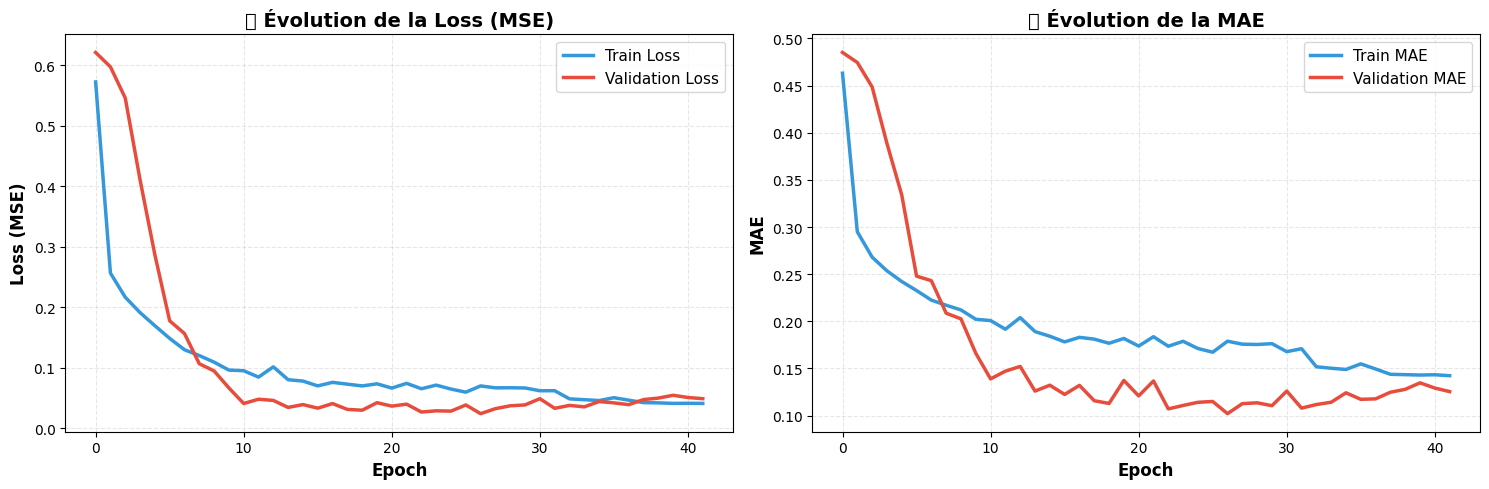


📊 Analyse de l'entraînement :
  ⚠️  Possible sur-apprentissage : val_loss > train_loss


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss (MSE)
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2.5, color='#3498db')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('📉 Évolution de la Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2.5, color='#3498db')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('📉 Évolution de la MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Analyse de la courbe
print("\n📊 Analyse de l'entraînement :")
if history.history['val_loss'][-1] < history.history['loss'][-1] * 1.1:
    print("  ✅ Bon apprentissage : pas de sur-apprentissage détecté")
else:
    print("  ⚠️  Possible sur-apprentissage : val_loss > train_loss")

---
## 🔍 ÉTAPE 9 : Qualité de la reconstruction

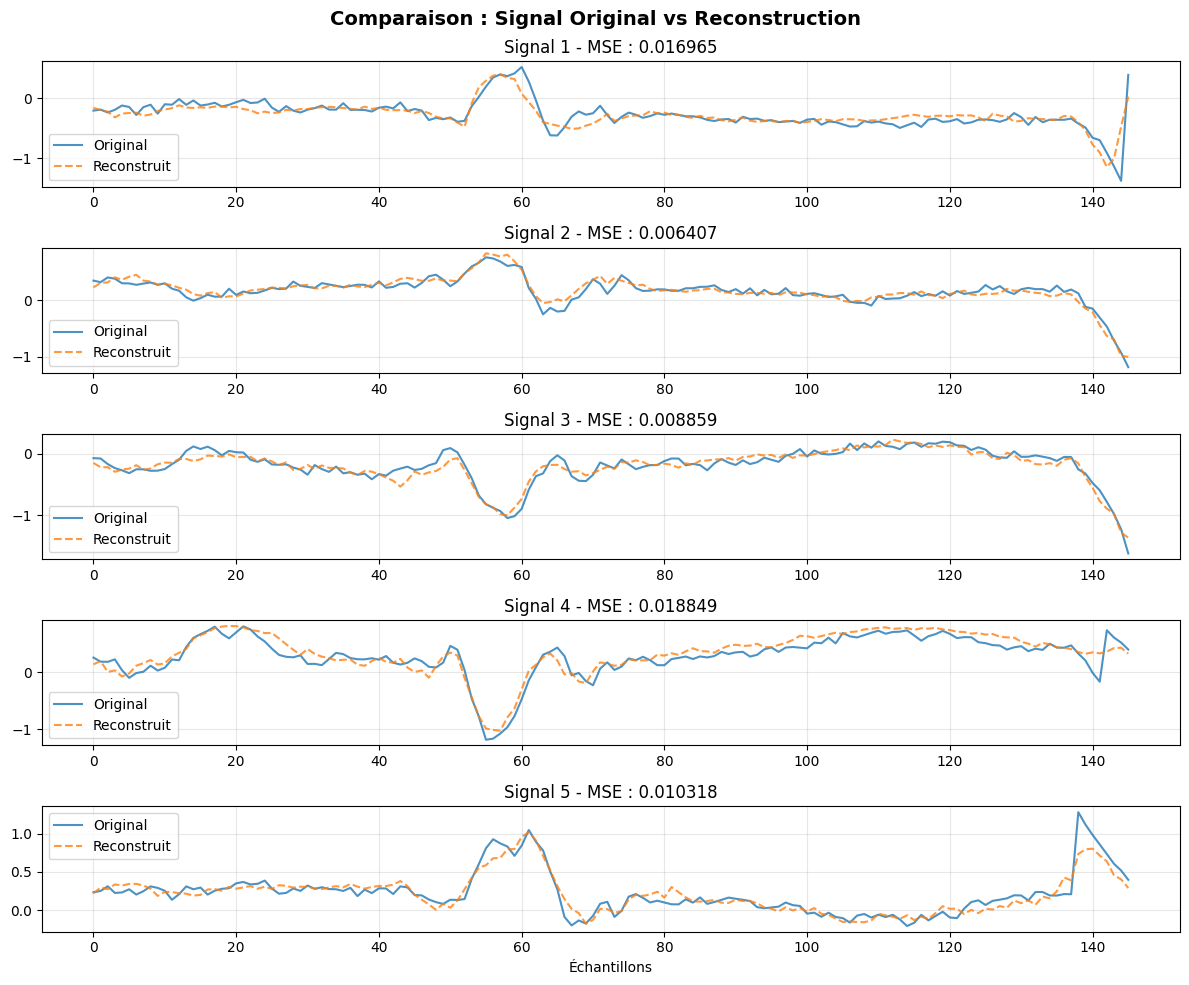

✓ Le modèle reconstruit bien les signaux normaux !


In [48]:
# Prédire sur quelques signaux de validation
decoded_signals = autoencoder.predict(X_val[:5], verbose=0)

# Visualiser
fig, axes = plt.subplots(5, 1, figsize=(12, 10))
fig.suptitle('Comparaison : Signal Original vs Reconstruction', fontsize=14, fontweight='bold')

for i in range(5):
    axes[i].plot(X_val[i].squeeze(), label='Original', linewidth=1.5, alpha=0.8)
    axes[i].plot(decoded_signals[i].squeeze(), label='Reconstruit', 
                 linestyle='--', linewidth=1.5, alpha=0.8)
    mse = np.mean((X_val[i] - decoded_signals[i])**2)
    axes[i].set_title(f'Signal {i+1} - MSE : {mse:.6f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    if i == 4:
        axes[i].set_xlabel('Échantillons')

plt.tight_layout()
plt.show()

print("✓ Le modèle reconstruit bien les signaux normaux !")

---
## 🎯 ÉTAPE 10 : Détection d'anomalies

**Principe :**
- Calculer l'**erreur de reconstruction (MSE)** pour chaque signal
- Signaux normaux → **faible erreur** (le modèle les connaît)
- Anomalies → **forte erreur** (le modèle ne les a jamais vues)

In [49]:
# Normaliser TOUS les signaux
X_norm = normalize_data(X)

# Ajouter la dimension canal (146,) → (146, 1)
X_input = X_norm[..., np.newaxis]

# Prédire (reconstruction)
print("⏳ Reconstruction de tous les signaux...")
reconstructions = autoencoder.predict(X_input, verbose=1)

# Enlever la dimension canal pour calculer le MSE
reconstructions = reconstructions.squeeze()  # (n_samples, 146)

# Calculer l'erreur de reconstruction (MSE) pour chaque signal
mse = np.mean(np.square(X_norm - reconstructions), axis=1)

print(f"\n✓ Erreurs de reconstruction calculées")
print(f"  - MSE moyenne (Classe N) : {np.mean(mse[y==0]):.6f}")
print(f"  - MSE moyenne (Classe R) : {np.mean(mse[y==1]):.6f}")
print(f"  - MSE moyenne (Classe V) : {np.mean(mse[y==2]):.6f}")

⏳ Reconstruction de tous les signaux...
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

✓ Erreurs de reconstruction calculées
  - MSE moyenne (Classe N) : 0.024699
  - MSE moyenne (Classe R) : 0.179427
  - MSE moyenne (Classe V) : 0.264160


---
## 🎚️ ÉTAPE 11 : Détermination du seuil de détection

**Méthode :** Seuil = Moyenne(MSE normaux) + 3 × Écart-type(MSE normaux)

In [50]:
# Calculer le seuil
threshold = np.mean(mse[y == 0]) + 3 * np.std(mse[y == 0])
anomalies = mse > threshold

print(f"✓ Seuil de détection : {threshold:.6f}")
print(f"  → Signaux avec MSE > {threshold:.6f} sont considérés comme ANOMALIES")

# Compter les détections
n_detected_N = np.sum(anomalies[y == 0])
n_detected_R = np.sum(anomalies[y == 1])
n_detected_V = np.sum(anomalies[y == 2])

print(f"\n📊 Résultats de détection :")
print(f"  - Classe N (Normal) : {n_detected_N}/{np.sum(y==0)} détectés comme anomalies ({n_detected_N/np.sum(y==0)*100:.1f}%)")
print(f"  - Classe R (Anomalie connue) : {n_detected_R}/{np.sum(y==1)} détectés ({n_detected_R/np.sum(y==1)*100:.1f}%)")
print(f"  - Classe V (Anomalie inconnue) : {n_detected_V}/{np.sum(y==2)} détectés ({n_detected_V/np.sum(y==2)*100:.1f}%)")

✓ Seuil de détection : 0.195256
  → Signaux avec MSE > 0.195256 sont considérés comme ANOMALIES

📊 Résultats de détection :
  - Classe N (Normal) : 53/5288 détectés comme anomalies (1.0%)
  - Classe R (Anomalie connue) : 36/111 détectés (32.4%)
  - Classe V (Anomalie inconnue) : 5/6 détectés (83.3%)


---
## 📈 ÉTAPE 12 : Visualisation des distributions d'erreurs

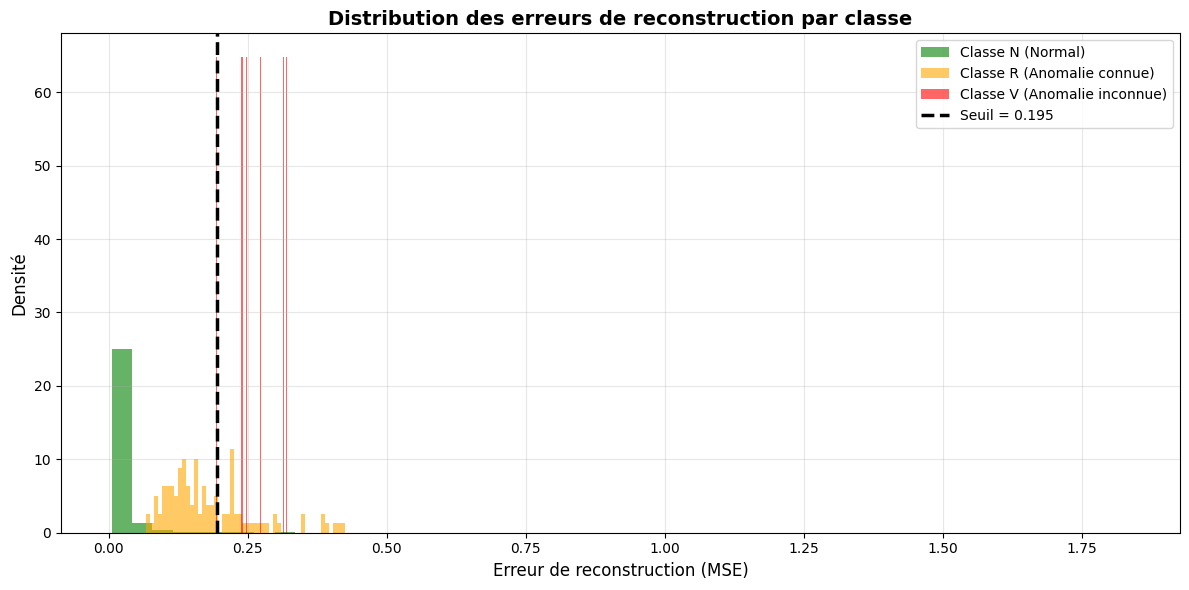

In [51]:
plt.figure(figsize=(12, 6))
plt.hist(mse[y==0], bins=50, alpha=0.6, label='Classe N (Normal)', color='green', density=True)
plt.hist(mse[y==1], bins=50, alpha=0.6, label='Classe R (Anomalie connue)', color='orange', density=True)
plt.hist(mse[y==2], bins=50, alpha=0.6, label='Classe V (Anomalie inconnue)', color='red', density=True)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2.5, label=f'Seuil = {threshold:.3f}')
plt.xlabel("Erreur de reconstruction (MSE)", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.title("Distribution des erreurs de reconstruction par classe", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 📊 ÉTAPE 13 : Métriques de performance

In [52]:
# Créer les labels : 0 = normal, 1 = anomalie
y_true = (y != 0).astype(int)  # Toutes les anomalies (R et V) = 1
y_pred = anomalies.astype(int)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("📊 Matrice de confusion :")
print("                Prédit Normal  Prédit Anomalie")
print(f"Vrai Normal         {cm[0,0]:6d}         {cm[0,1]:6d}")
print(f"Vrai Anomalie       {cm[1,0]:6d}         {cm[1,1]:6d}")

# Rapport de classification
print("\n📈 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalie'], digits=3))

# AUC-ROC
auc_score = roc_auc_score(y_true, mse)
print(f"✓ AUC-ROC Score : {auc_score:.3f}")

📊 Matrice de confusion :
                Prédit Normal  Prédit Anomalie
Vrai Normal           5235             53
Vrai Anomalie           76             41

📈 Rapport de classification :
              precision    recall  f1-score   support

      Normal      0.986     0.990     0.988      5288
    Anomalie      0.436     0.350     0.389       117

    accuracy                          0.976      5405
   macro avg      0.711     0.670     0.688      5405
weighted avg      0.974     0.976     0.975      5405

✓ AUC-ROC Score : 0.986


---
## ✅ Résumé final

In [53]:
print("="*80)
print("✅ PROJET TERMINÉ - RÉSUMÉ")
print("="*80)
print("\n✓ Autoencodeur entraîné sur signaux normaux uniquement")
print("✓ Détection d'anomalies basée sur l'erreur de reconstruction")
print(f"✓ Seuil optimal : {threshold:.6f}")
print(f"✓ AUC-ROC : {auc_score:.3f}")
print("\n📝 Prochaines étapes pour le rapport :")
print("   1. Justifier le choix de l'architecture")
print("   2. Expliquer la méthode de détermination du seuil")
print("   3. Analyser les faux positifs et faux négatifs")
print("   4. Tester la robustesse au bruit")
print("   5. Mesurer le temps d'inférence (contrainte Raspberry Pi)")
print("="*80)

✅ PROJET TERMINÉ - RÉSUMÉ

✓ Autoencodeur entraîné sur signaux normaux uniquement
✓ Détection d'anomalies basée sur l'erreur de reconstruction
✓ Seuil optimal : 0.195256
✓ AUC-ROC : 0.986

📝 Prochaines étapes pour le rapport :
   1. Justifier le choix de l'architecture
   2. Expliquer la méthode de détermination du seuil
   3. Analyser les faux positifs et faux négatifs
   4. Tester la robustesse au bruit
   5. Mesurer le temps d'inférence (contrainte Raspberry Pi)
